In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
X = pd.read_csv('../../../data/processed/role_scores_normalized.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
cols = ['M_A_Score','M_S_Score',
    'CM_A_Score','CM_S_Score','CM_D_Score','CM_Au_Score',
    'AP_A_Score','AP_S_Score',
    'DLP_S_Score','DLP_D_Score',
    'RP_S_Score','C_S_Score',
    'B2B_S_Score',
    'BWM_S_Score','BWM_D_Score']

In [5]:
k1 = 2
km_top = KMeans(
    n_clusters=k1,
    init="k-means++",
    n_init="auto",
    random_state=42
)

top_labels = km_top.fit_predict(X_scaled)
X["cluster_lvl1"] = top_labels

In [6]:
X["cluster_lvl2"] = -1  # initialize

for c in np.unique(top_labels):
    
    # indices of players in top-level cluster c
    idx = (X["cluster_lvl1"] == c)
    
    # extract subset of normalized vectors
    X_sub = X_scaled[idx]
    
    # choose number of subclusters inside this group
    k2 = 2  # you can change to 3 or 4 per group if needed
    
    km_sub = KMeans(
        n_clusters=k2,
        init="k-means++",
        n_init="auto",
        random_state=42
    )
    
    sub_labels = km_sub.fit_predict(X_sub)
    
    # assign these subcluster labels back to X
    X.loc[idx, "cluster_lvl2"] = sub_labels


In [7]:
X["hier_cluster"] = (
    X["cluster_lvl1"].astype(str) + "_" + X["cluster_lvl2"].astype(str)
)


In [8]:
cluster_profiles = (
    X.groupby("hier_cluster")[cols]
      .mean()
      .sort_index()
)

print(cluster_profiles)


              M_A_Score  M_S_Score  CM_A_Score  CM_S_Score  CM_D_Score  \
hier_cluster                                                             
0_0           -0.868718  -0.220321   -0.175152    0.344084    0.401331   
0_1           -1.444141  -0.495023    0.083389    0.970433    0.695396   
1_0            1.123759   0.717870    0.526354   -0.066716   -1.499005   
1_1            0.043552   0.387029    0.747318    0.660643   -0.788349   

              CM_Au_Score  AP_A_Score  AP_S_Score  DLP_S_Score  DLP_D_Score  \
hier_cluster                                                                  
0_0             -0.063811   -0.961858   -1.080481    -0.592236    -0.350173   
0_1              0.890920   -0.699609   -0.704944     0.302683     0.821290   
1_0             -0.052943    0.995958    0.832213     0.262479     0.039664   
1_1              0.840743    0.447136    0.357251     0.646049     0.836998   

              RP_S_Score  C_S_Score  B2B_S_Score  BWM_S_Score  BWM_D_Score  
hie

<Axes: xlabel='pca1', ylabel='pca2'>

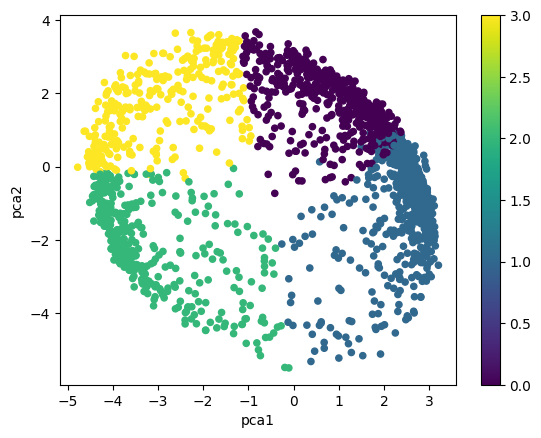

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X["pca1"] = X_pca[:, 0]
X["pca2"] = X_pca[:, 1]

# Convert cluster labels to numeric values for plotting
cluster_numeric = pd.factorize(X["hier_cluster"])[0]
X.plot.scatter("pca1", "pca2", c=cluster_numeric, colormap="viridis")


ValueError: 
    Invalid element(s) received for the 'size' property of scattergl.marker
        Invalid elements include: [-0.405804653644222, -0.037403691039419, -0.2197064078821394, -0.4358278616399328, -0.1891125242234019, -0.5873972590098537, -0.3978142128354242, -0.3775521070066854, -0.2177440833910943, -0.3437644601890569]

    The 'size' property is a number and may be specified as:
      - An int or float in the interval [0, inf]
      - A tuple, list, or one-dimensional numpy array of the above

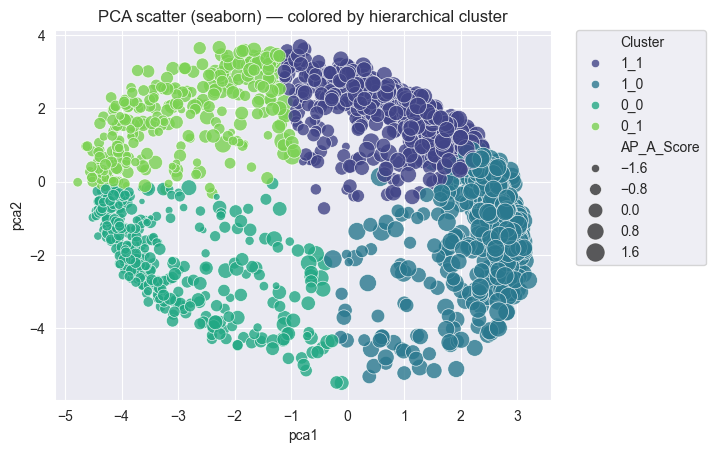

In [11]:
import seaborn as sns
from IPython.display import display

# New cell: interactive visualization + cluster summaries
import plotly.express as px

# prepare dataframe for plotting and summaries
df_with_clusters = X.copy()
df_with_clusters["Cluster"] = df_with_clusters["hier_cluster"]

# 1) seaborn styled scatter (static, visually "cool")
sns.set_style("darkgrid")
palette = sns.color_palette("viridis", n_colors=df_with_clusters["Cluster"].nunique())
ax = sns.scatterplot(
    data=df_with_clusters,
    x="pca1",
    y="pca2",
    hue="Cluster",
    palette=palette,
    size="AP_A_Score",       # visual weight by a score
    sizes=(20, 200),
    alpha=0.8,
    edgecolor="w",
    linewidth=0.5
)
ax.set_title("PCA scatter (seaborn) — colored by hierarchical cluster")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
# (no plt.show() needed in Jupyter, cell output will render)
# 2) interactive Plotly scatter (hover, zoom, filter)
fig = px.scatter(
    df_with_clusters,
    x="pca1",
    y="pca2",
    color="Cluster",
    size="AP_A_Score",
    hover_data=cols + ["cluster_lvl1", "cluster_lvl2"],
    title="Interactive PCA scatter — hier_cluster (click legend items to filter)",
    opacity=0.8
)
fig.update_traces(marker=dict(line=dict(width=0.5, color="DarkSlateGrey")))
fig.update_layout(width=900, height=600)
fig.show()

In [13]:
df_engineered = pd.read_csv('../../../data/processed/role_scores_normalized.csv')
df_meta = pd.read_csv('../../../data/processed/meta_data.csv')
df_engineered["Cluster"] = X["hier_cluster"].values
df_with_clusters = df_meta.join(df_engineered[["Cluster"]])

In [14]:
# Compute medoid indices for each cluster
medoid_indices = []
for c in df_with_clusters["Cluster"].unique():
	cluster_mask = df_with_clusters["Cluster"] == c
	cluster_points = X_scaled[cluster_mask]
	cluster_center = cluster_points.mean(axis=0)
	
	# Find the point closest to the cluster center
	distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
	medoid_idx = np.where(cluster_mask)[0][np.argmin(distances)]
	medoid_indices.append(medoid_idx)

df_medoids = df_with_clusters.iloc[medoid_indices].copy()

In [ ]:
for c in df_with_clusters["Cluster"].unique():
    print(f"\n=== Cluster {c}: Top 10 by CA ===")
    display(
        df_with_clusters[df_with_clusters["Cluster"] == c]
        [["Name","Club","CA","PA"]]
        .sort_values("CA", ascending=False)
        .head(10)
    )


=== Cluster 1_1: Top 10 by AP_A_Score ===


,AP_A_Score,AP_S_Score,M_A_Score,M_S_Score,cluster_lvl1,cluster_lvl2
1247,1.534526,1.373562,0.063516,-0.329267,1,1
813,1.531352,1.163161,0.288111,0.178815,1,1
1635,1.527852,1.482761,0.708018,-0.275784,1,1
1102,1.494079,1.076991,-1.069447,-0.319348,1,1
1445,1.490859,1.468807,0.837312,-0.096899,1,1
75,1.478814,1.532300,-0.101475,0.141646,1,1
807,1.459492,1.017329,-0.473366,-1.362823,1,1
1101,1.452298,1.249336,0.756187,-0.023794,1,1
737,1.448605,1.836335,-0.569354,-0.877775,1,1
106,1.418248,1.593398,0.719705,0.062253,1,1



=== Cluster 1_0: Top 10 by AP_A_Score ===


,AP_A_Score,AP_S_Score,M_A_Score,M_S_Score,cluster_lvl1,cluster_lvl2
1809,1.854676,1.234004,1.323619,0.498585,1,0
825,1.846869,1.514189,0.812220,0.095924,1,0
1610,1.839585,1.464626,-0.334622,-0.389898,1,0
610,1.832076,1.874656,0.655332,0.128894,1,0
511,1.800951,1.555366,1.223744,0.123784,1,0
1730,1.795554,1.262589,1.449473,0.164027,1,0
254,1.752724,2.470940,-0.753092,-0.964851,1,0
1648,1.742682,1.183993,1.641102,0.252844,1,0
574,1.733054,1.567217,1.123980,0.539028,1,0
507,1.689327,1.585461,1.122785,0.535260,1,0



=== Cluster 0_0: Top 10 by AP_A_Score ===


,AP_A_Score,AP_S_Score,M_A_Score,M_S_Score,cluster_lvl1,cluster_lvl2
637,0.738886,0.616799,-0.703959,-0.617635,0,0
774,0.627804,0.559400,-0.615906,-0.284250,0,0
1189,0.527741,-0.427239,1.600752,0.313139,0,0
567,0.501448,0.395264,-0.415596,-0.560392,0,0
1257,0.378618,0.122930,-0.968192,-0.523813,0,0
613,0.348944,0.290307,-1.836614,-1.410164,0,0
584,0.270523,0.503302,-0.163292,-0.893372,0,0
523,0.270159,0.051733,-1.135099,0.606199,0,0
451,0.269218,0.070354,0.590615,0.269218,0,0
462,0.108128,-0.073958,0.273660,-0.238702,0,0



=== Cluster 0_1: Top 10 by AP_A_Score ===


,AP_A_Score,AP_S_Score,M_A_Score,M_S_Score,cluster_lvl1,cluster_lvl2
424,1.374489,1.522583,-0.302270,-1.587377,0,1
302,1.060998,1.769067,-1.237927,-1.540072,0,1
780,0.796632,0.658817,-0.752360,-1.458518,0,1
390,0.756169,0.931635,-2.083180,-0.881508,0,1
181,0.446921,0.797208,-1.852941,-1.109909,0,1
360,0.327332,0.507783,-1.788866,-1.356877,0,1
311,0.307256,0.464640,-1.409657,-1.041747,0,1
1066,0.264585,-0.535054,-1.676286,-0.045954,0,1
40,0.248633,0.543252,-0.898040,-0.794811,0,1
1191,0.245901,0.313177,-1.250711,-0.703872,0,1
